In [1]:
#! pip install shap
#! pip install interpret
#! pip install transformers
#! pip install datasets

In [2]:
import pandas as pd
import shap
import sklearn

# a classic housing price dataset
X,y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


LinearRegression()

In [3]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Model coefficients:

MedInc = 0.42563
HouseAge = 0.01033
AveRooms = -0.1161
AveBedrms = 0.66385
Population = 3e-05
AveOccup = -0.26096
Latitude = -0.46734
Longitude = -0.46272


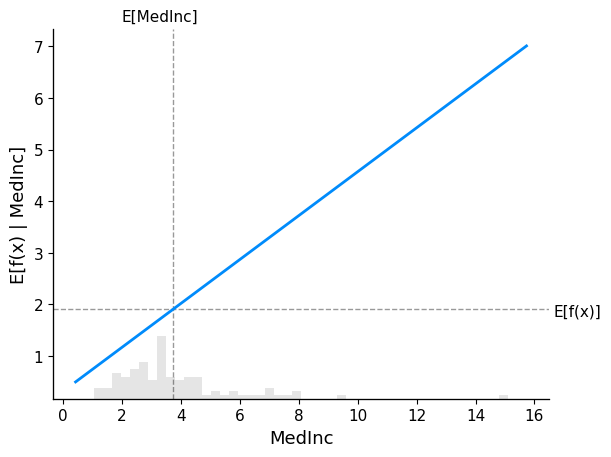

In [4]:
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Exact explainer: 1001it [00:21, 30.04it/s]                         


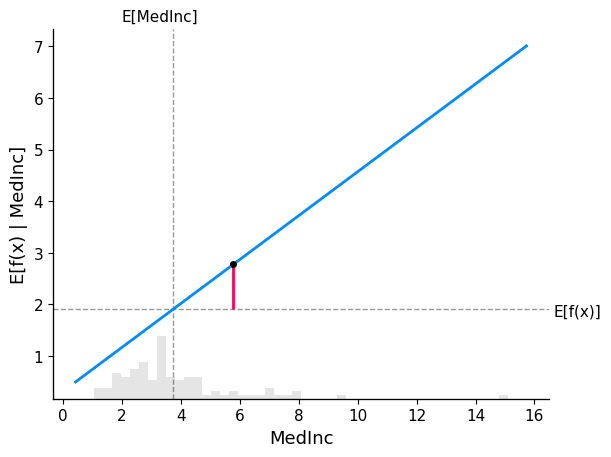

In [5]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 1
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

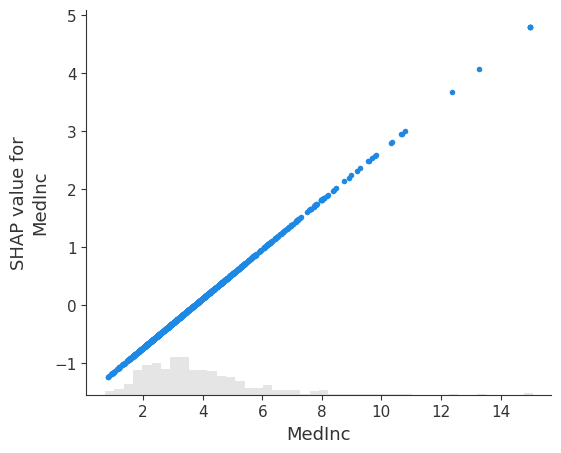

In [6]:
shap.plots.scatter(shap_values[:,"MedInc"])

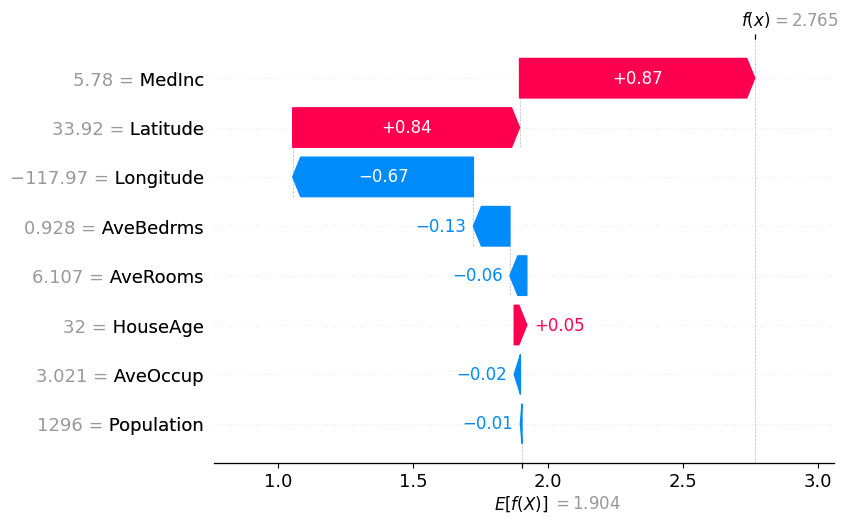

In [7]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

Exact explainer: 1001it [00:15, 17.75it/s]                         


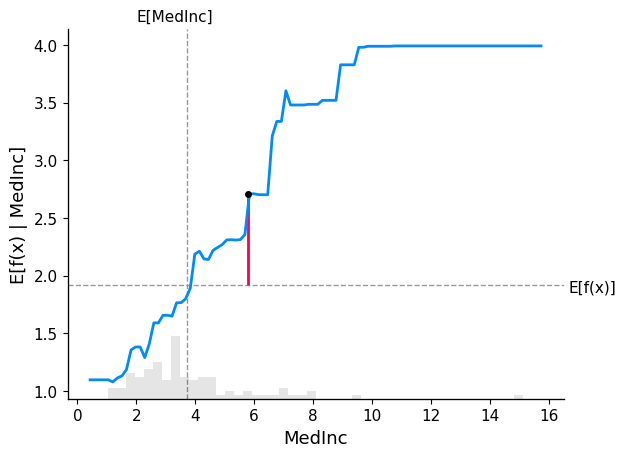

In [8]:
# fit a GAM model to the data
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "MedInc", model_ebm.predict, X100, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

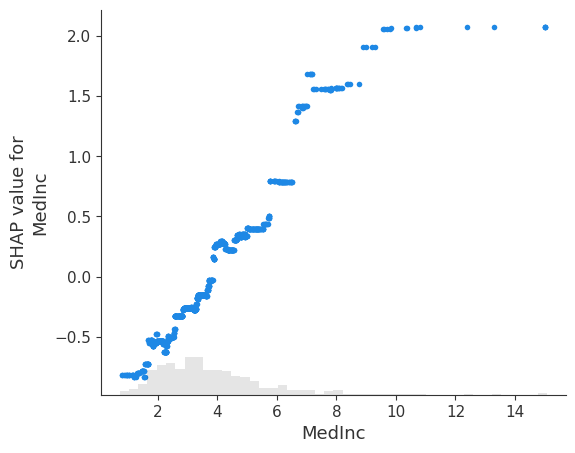

In [9]:
shap.plots.scatter(shap_values_ebm[:,"MedInc"])

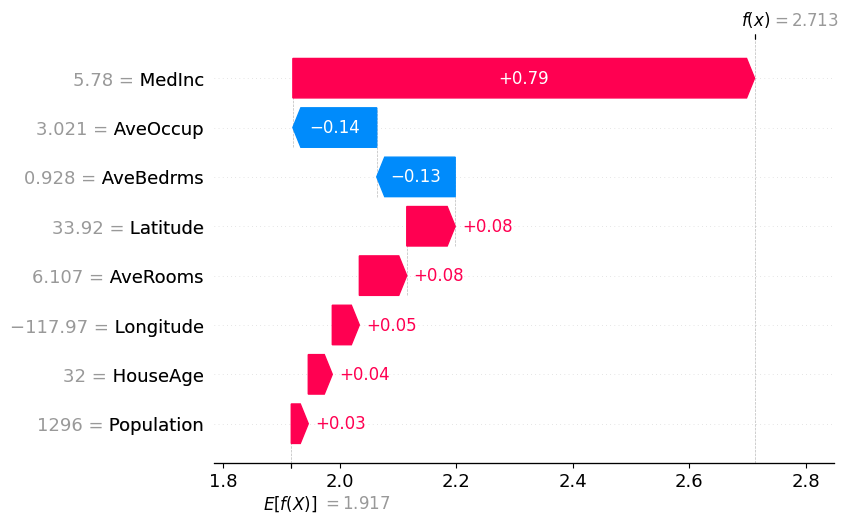

In [10]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


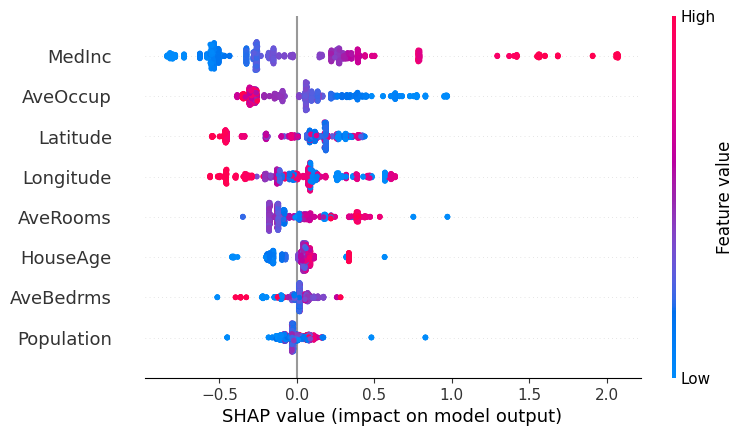

In [11]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values_ebm)

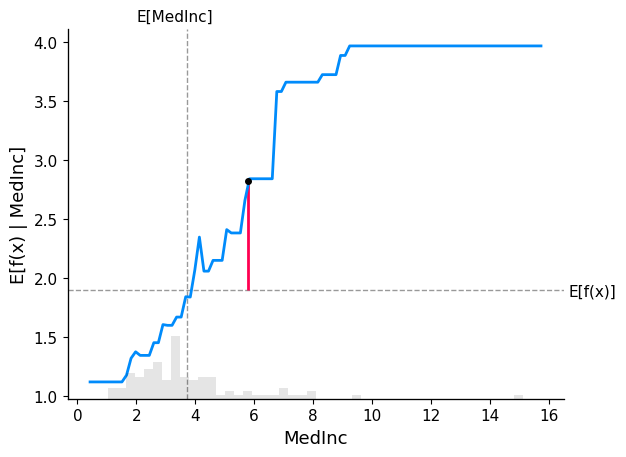

In [12]:
# train XGBoost model
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "MedInc", model_xgb.predict, X100, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_xgb[sample_ind:sample_ind+1,:]
)

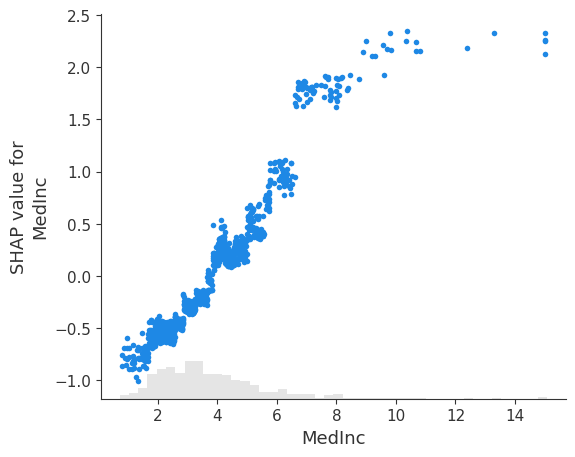

In [13]:
shap.plots.scatter(shap_values_xgb[:,"MedInc"])

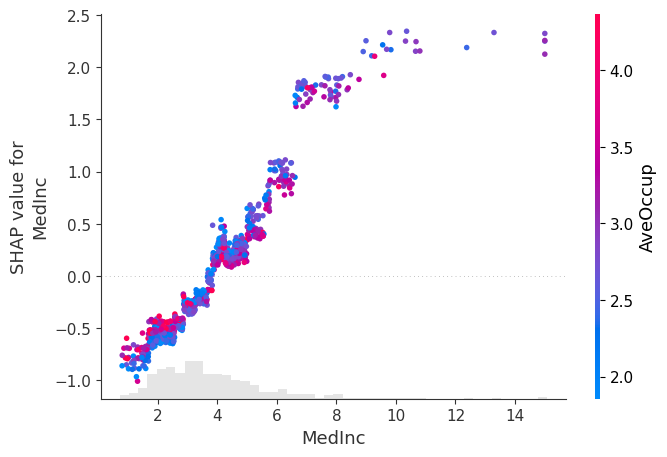

In [14]:
shap.plots.scatter(shap_values_xgb[:,"MedInc"], color=shap_values)

In [15]:
# a classic adult census dataset price dataset
X_adult,y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)

def model_adult_proba(x):
    return model_adult.predict_proba(x)[:,1]
def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:,1] - p[:,0]

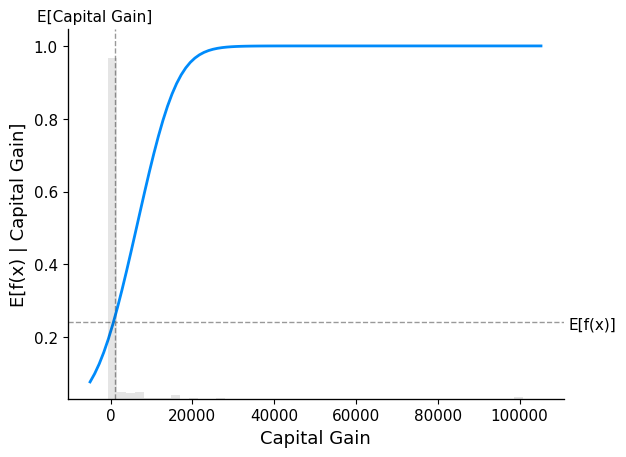

In [16]:
# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Capital Gain", model_adult_proba, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)


In [17]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])

Permutation explainer: 1001it [01:02, 14.13it/s]                         


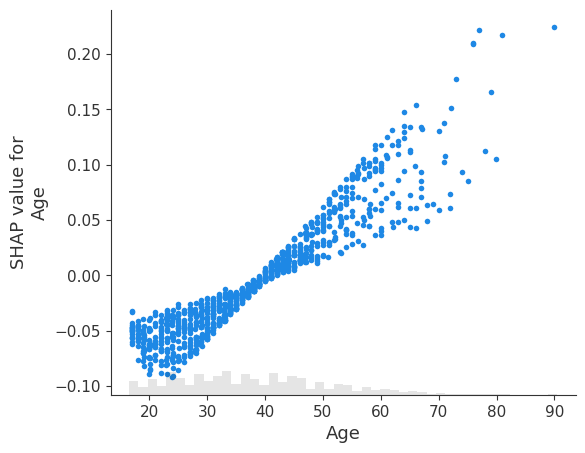

In [18]:
shap.plots.scatter(shap_values_adult[:,"Age"])

In [19]:
# compute the SHAP values for the linear model
explainer_log_odds = shap.Explainer(model_adult_log_odds, background_adult)
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])

Permutation explainer: 1001it [01:05, 13.34it/s]                          


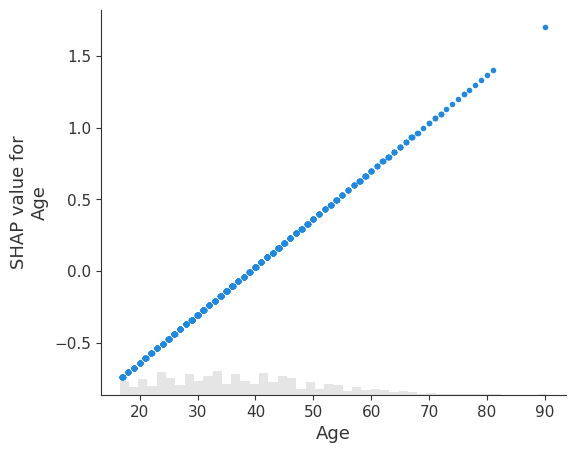

In [20]:
shap.plots.scatter(shap_values_adult_log_odds[:,"Age"])

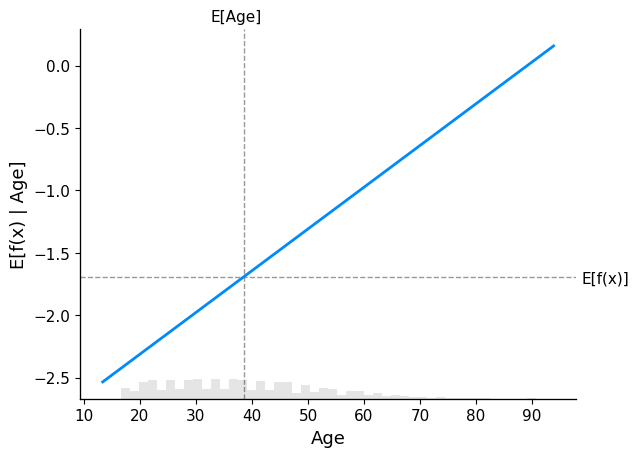

In [21]:
# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Age", model_adult_log_odds, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)


In [22]:
# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_adult, y_adult*1, eval_metric="logloss")

# compute SHAP values
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# set a display version of the data to use for plotting (has string values)
shap_values.display_data = shap.datasets.adult(display=True)[0].values

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
 97%|=================== | 31474/32561 [00:20<00:00]       

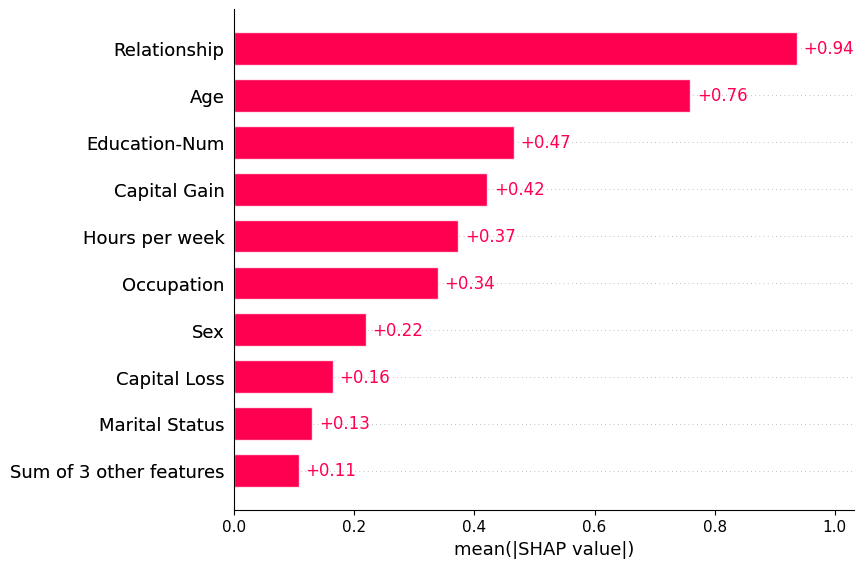

In [23]:
shap.plots.bar(shap_values)

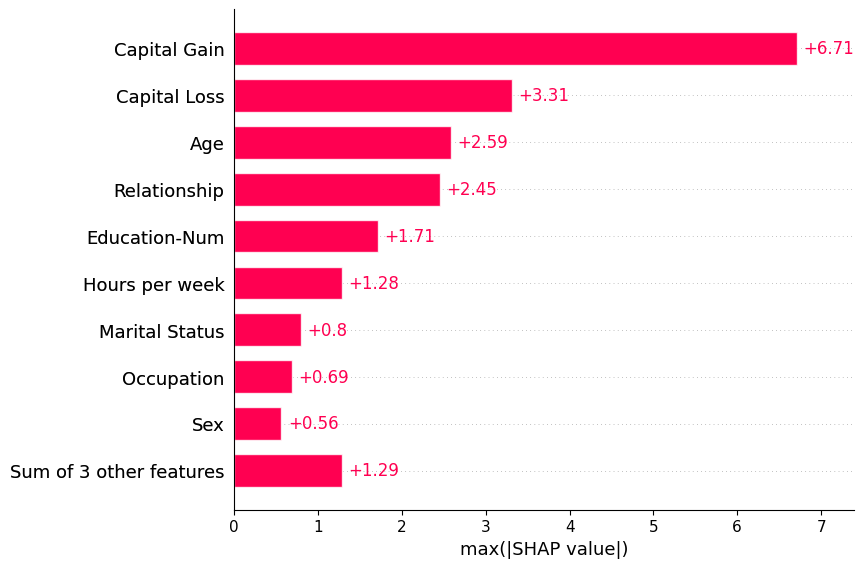

In [24]:
shap.plots.bar(shap_values.abs.max(0))


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


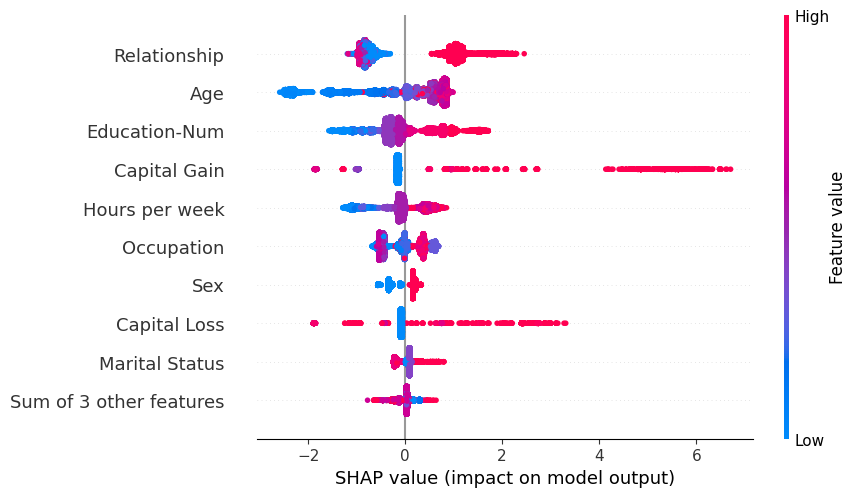

In [25]:
shap.plots.beeswarm(shap_values)


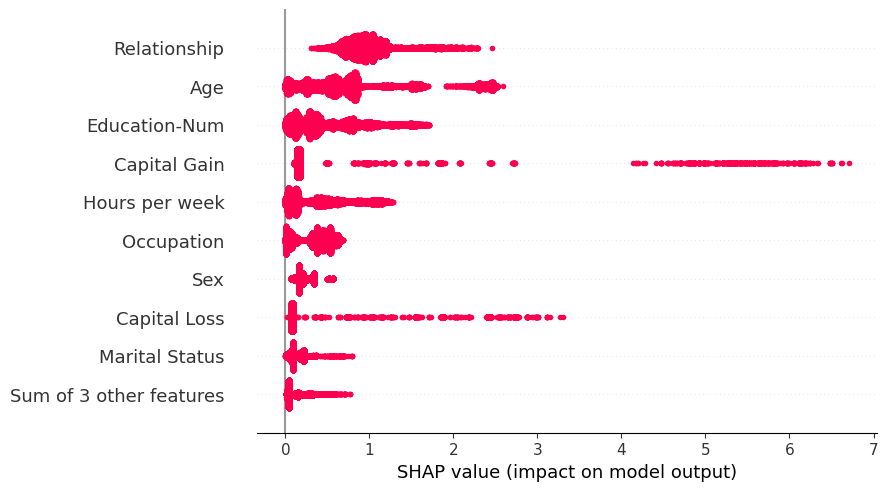

In [26]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")


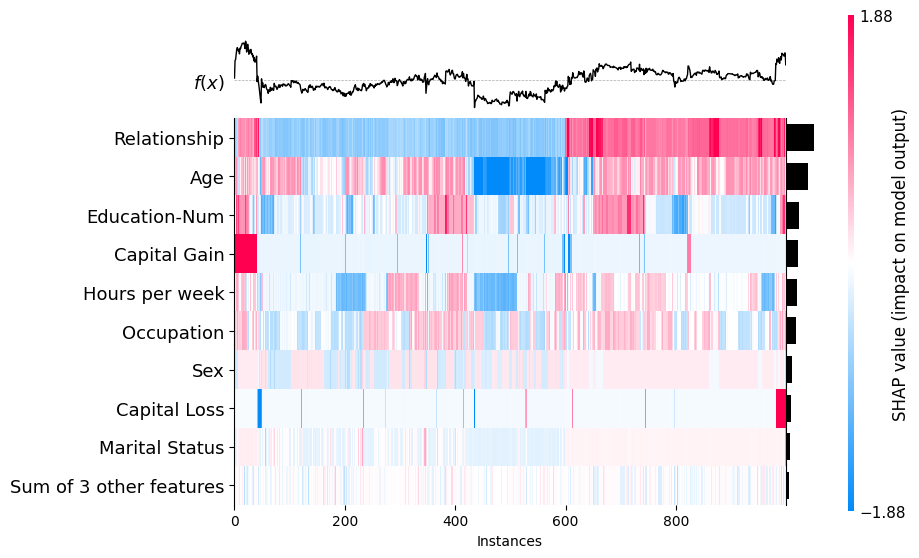

In [27]:
shap.plots.heatmap(shap_values[:1000])


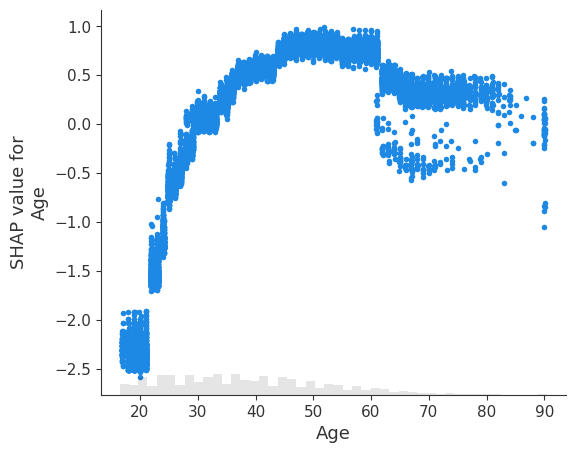

In [28]:
shap.plots.scatter(shap_values[:,"Age"])


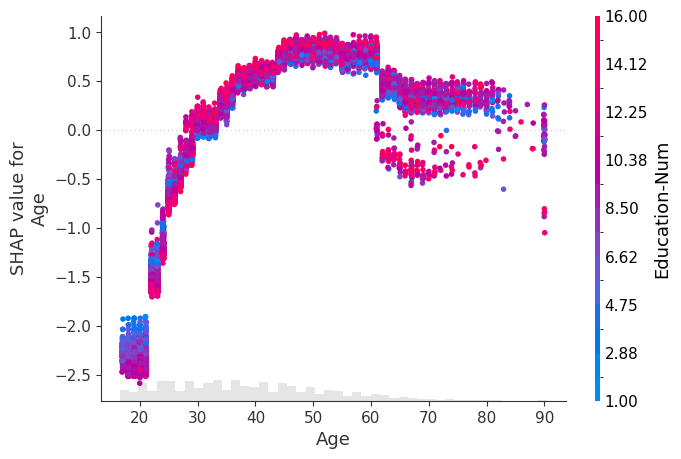

In [29]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values)


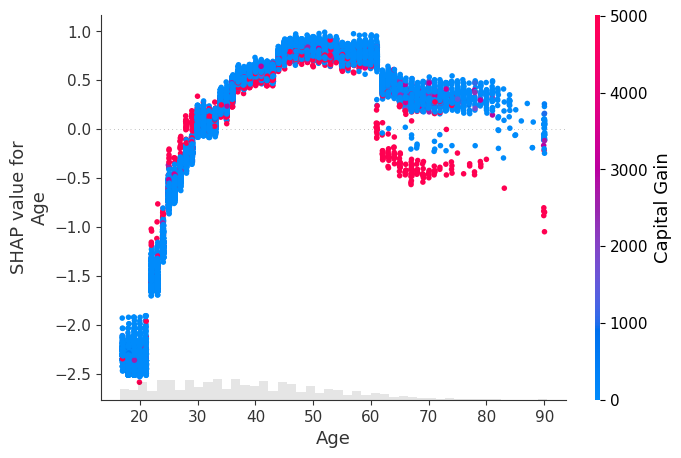

In [30]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,"Capital Gain"])


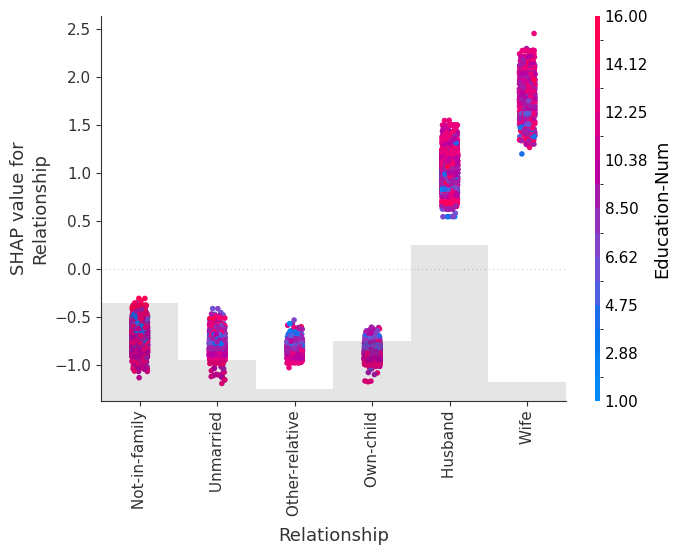

In [31]:
shap.plots.scatter(shap_values[:,"Relationship"], color=shap_values)


In [32]:
clustering = shap.utils.hclust(X_adult, y_adult)


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


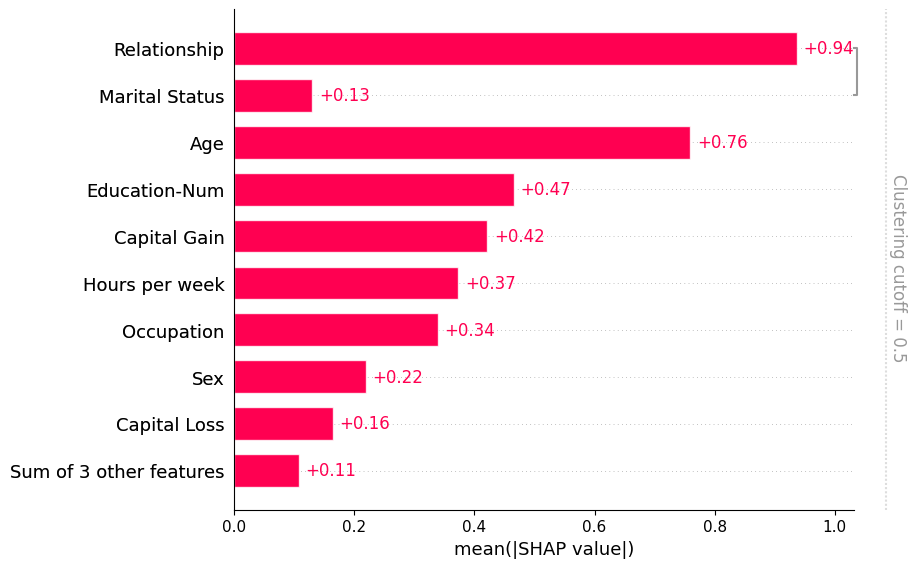

In [33]:
shap.plots.bar(shap_values, clustering=clustering)


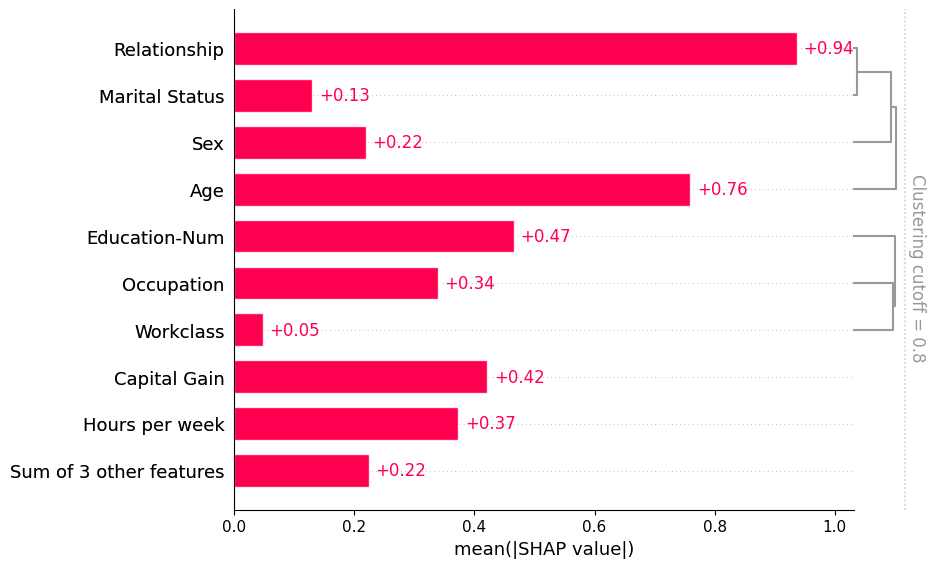

In [34]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)


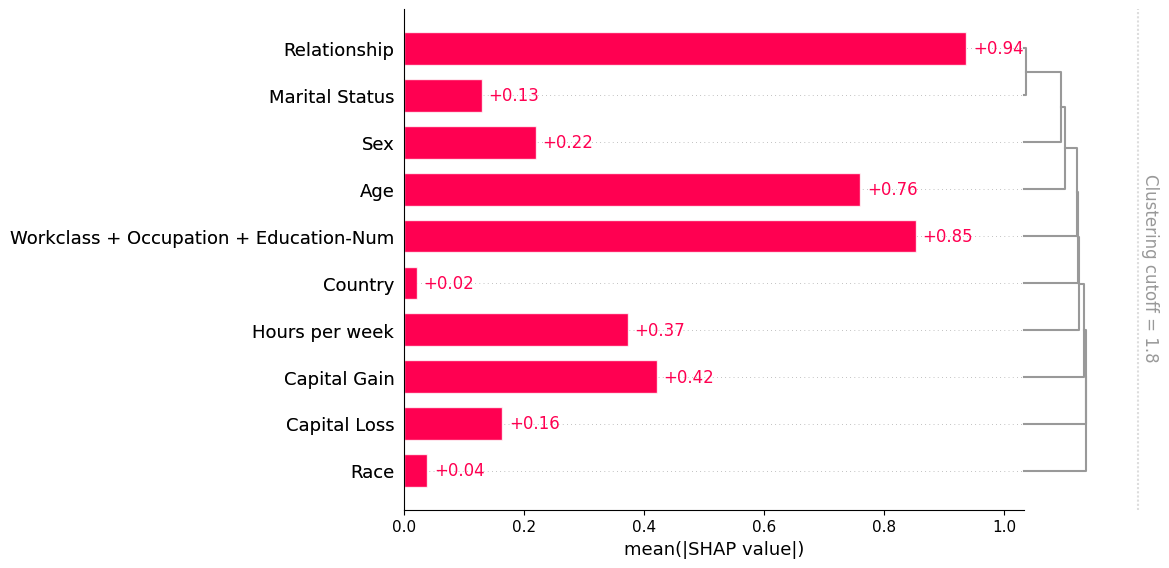

In [35]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)


In [36]:
import transformers
import datasets
import torch
import numpy as np
import scipy as sp

# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
).cuda()

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
imdb_train = datasets.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:10], fixed_context=1, batch_size=2)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 4it [00:24,  4.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 5it [00:30,  4.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 6it [00:39,  6.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 8it [00:49,  5.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 9it [00:58,  6.58s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 10it [01:08,  7.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 11it [01:17,  7.74s/it]


In [37]:
shap.plots.text(shap_values[2])


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


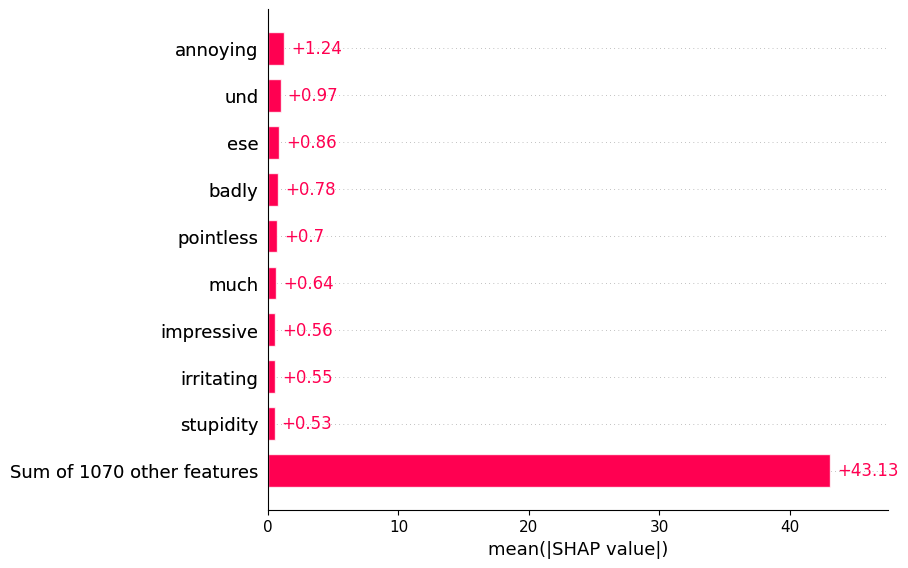

In [38]:
shap.plots.bar(shap_values.abs.mean(0))


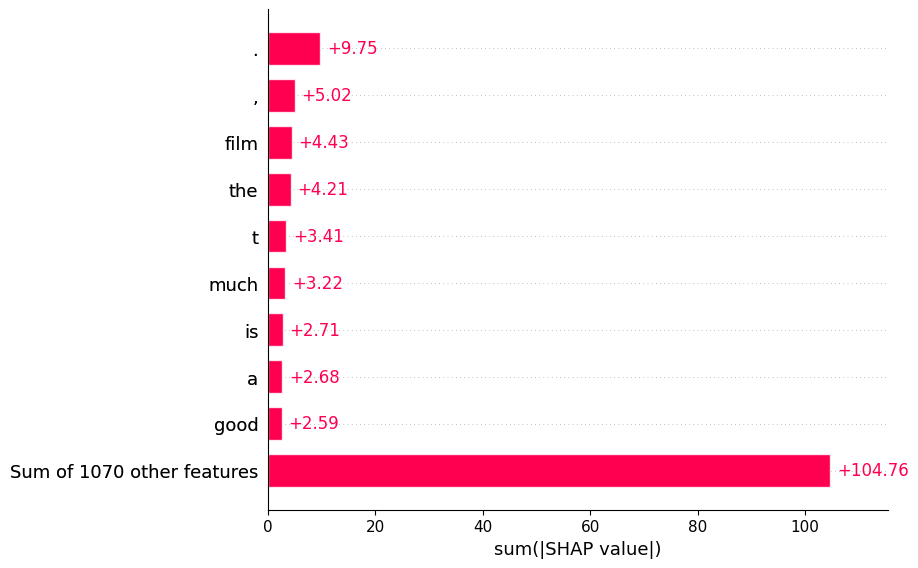

In [39]:
shap.plots.bar(shap_values.abs.sum(0))
